<a href="https://colab.research.google.com/github/girotodenis/ReconhecimentoImagemVisaoComputacional/blob/master/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOME COMPLETO DOS INTEGRANTES DO GRUPO:
**Davi Miranda Gonçalves**, 
**Denis SIlva Giroto**,
**Naiara Moura Pires**

MATRÍCULAS DOS INTEGRANTES DO GRUPO:
**1931143030**,
**1931143029**,
**1931143033**

In [13]:
!git clone -l -s https://github.com/girotodenis/ReconhecimentoImagemVisaoComputacional.git projeto
#%cd cloned-repo
!ls

Cloning into 'projeto'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 209 (delta 8), reused 8 (delta 1), pack-reused 184
Receiving objects: 100% (209/209), 95.61 MiB | 37.30 MiB/s, done.
Resolving deltas: 100% (87/87), done.
foto_1000.png  foto_2000.png  projeto	sample_data
foto_1500.png  foto_500.png   projetox	yolov4.weights


In [19]:
!curl -LJO https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights --output yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   638  100   638    0     0   3544      0 --:--:-- --:--:-- --:--:--  3544
100  236M  100  236M    0     0  84.3M      0  0:00:02  0:00:02 --:--:--  108M
curl: Saved to filename 'yolov3.weights'


In [1]:
from google.colab.patches import cv2_imshow

import numpy as np
import cv2
import imutils

import time 


In [2]:
net = cv2.dnn.readNet('yolov3.weights','./projeto/yolov3.cfg')

In [23]:
classes = []
with open('./projeto/coco.names','r')as f:
  classes = [line.strip() for line in f.readlines()]
print(classes)

layer_names = net.getLayerNames()
outputLayers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
print(outputLayers)

cores = np.random.uniform(0,255,size=(len(classes), 3))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
['yolo_82', 'yolo_94', 'yolo_106']


In [24]:
def encontrar_objetos_dnn(outs):
  class_ids = []
  confidences = []
  boxes = []

  for out in outs:
    for detection in out:
      scores = detection[5:]
      class_id = np.argmax(scores)
      confidence = scores[class_id]
      
      if confidence>0.4:
        x,y,w,h,cx,cy = calcula_box(detection,width,height)
        boxes.append([x,y,w,h,cx,cy])
        confidences.append(confidence)
        class_ids.append(class_id)
  return class_ids, confidences, boxes

In [25]:
def calcula_box(detection, width, height):
  center_x = int(detection[0]*width)
  center_y = int(detection[1]*height)
  w = int(detection[2]*width)
  h = int(detection[3]*height)
  x = int(center_x - w/2)
  y = int(center_y - h/2)
  return [x,y,w,h,center_x,center_y]

In [32]:
def desenha_box(frame, boxes, class_ids, confidences):
  for i in range(len(boxes)):
    x,y,w,h,cx,cy = boxes[i]
    label = str(classes[class_ids[i]])
    label += ' '+ str(round(confidences[i],2))
    cor = cores[class_ids[i]]
    cv2.rectangle(frame,(x ,y),(x+w, y+h),cor, 2)
    cv2.putText(frame, label, (x, y+30), cv2.FONT_HERSHEY_PLAIN,1,(255,255,255),2)



In [27]:
subtracao = cv2.bgsegm.createBackgroundSubtractorMOG()  # Pega o fundo e subtrai do que está se movendo
def preprocesso_encontrar_objetos_bordas(frame1):
  grey = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)  # Pega o frame e transforma para preto e branco
  blur = cv2.GaussianBlur(grey, (3, 3), 5)  # Faz um blur para tentar remover as imperfeições da imagem
  img_sub = subtracao.apply(blur)  # Faz a subtração da imagem aplicada no blur
  dilat = cv2.dilate(img_sub, np.ones((5, 5)))  # "Engrossa" o que sobrou da subtração
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Cria uma matriz 5x5, em que o formato da matriz entre 0 e 1 forma uma elipse dentro
  dilatada = cv2.morphologyEx(dilat, cv2.MORPH_CLOSE, kernel)  # Tenta preencher todos os "buracos" da imagem
  dilatada = cv2.morphologyEx(dilatada, cv2.MORPH_CLOSE, kernel)
  return dilatada

In [28]:
def desenha_retangulo_objeto(original, objeto_movimento):
  contorno, img = cv2.findContours(objeto_movimento, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for (i, c) in enumerate(contorno):
    (x, y, w, h) = cv2.boundingRect(c)
    validar_contorno = (w >= 50) and (h >= 50)
    if not validar_contorno:
        continue
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)

960 540


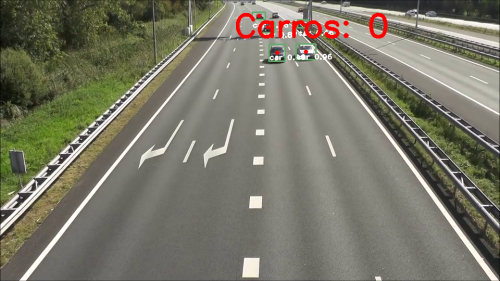

25 [[484, 23, 25, 14, 497, 30], [501, 42, 26, 20, 514, 52], [571, 38, 21, 15, 582, 46], [516, 85, 31, 32, 532, 101], [568, 84, 38, 30, 587, 99]] [0.86042637, 0.86703897, 0.45730206, 0.96400505, 0.9613189] [2, 2, 2, 2, 2]


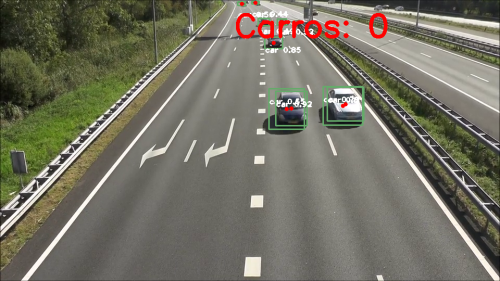

50 [[516, 170, 68, 78, 550, 209], [620, 166, 76, 74, 658, 203], [456, 3, 15, 7, 464, 7], [483, 2, 14, 5, 490, 5], [495, 35, 22, 14, 506, 42], [532, 36, 18, 12, 541, 42], [508, 71, 34, 22, 525, 82], [628, 167, 70, 65, 663, 200], [529, 175, 60, 66, 559, 208]] [0.551651, 0.79146343, 0.5620314, 0.43794703, 0.49476996, 0.51940775, 0.8473019, 0.79724944, 0.9156697] [2, 2, 2, 2, 2, 2, 2, 2, 2]
Carros detectados: 1


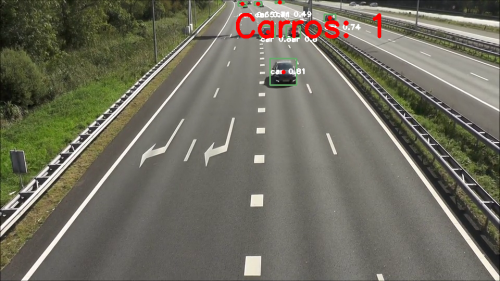

75 [[457, 3, 16, 8, 465, 7], [488, 3, 14, 7, 495, 7], [528, 2, 17, 4, 537, 4], [622, 27, 22, 14, 633, 34], [499, 50, 29, 21, 514, 61], [549, 50, 27, 22, 563, 61], [518, 112, 51, 51, 544, 138]] [0.648657, 0.7142271, 0.48777065, 0.73566604, 0.8548855, 0.798131, 0.81271785] [2, 2, 2, 2, 2, 2, 2]


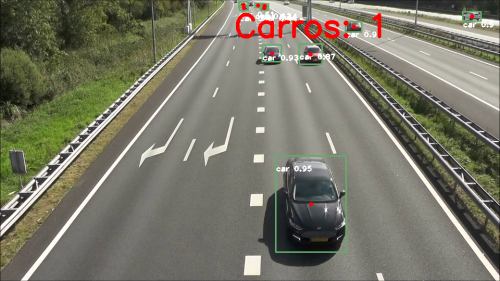

100 [[529, 299, 135, 185, 597, 392], [458, 3, 18, 11, 467, 9], [489, 6, 12, 8, 495, 10], [501, 7, 14, 8, 508, 11], [459, 10, 17, 9, 468, 15], [500, 11, 14, 8, 507, 15], [888, 22, 35, 18, 906, 31], [663, 41, 31, 20, 679, 51], [503, 86, 37, 32, 522, 102], [574, 84, 44, 39, 596, 104]] [0.94574267, 0.6051677, 0.41644529, 0.4399845, 0.6085919, 0.43643108, 0.90187776, 0.9070514, 0.92923343, 0.87393504] [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


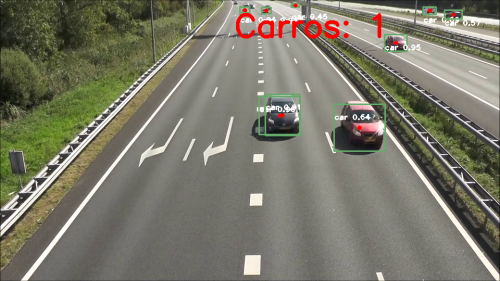

125 [[497, 185, 79, 73, 537, 222], [641, 200, 98, 90, 690, 245], [559, 7, 15, 6, 567, 10], [460, 13, 19, 11, 470, 19], [502, 14, 18, 12, 511, 20], [812, 13, 25, 14, 825, 20], [853, 19, 34, 17, 870, 28], [738, 66, 43, 32, 760, 82], [509, 181, 66, 79, 542, 221]] [0.9563539, 0.63879955, 0.44896945, 0.94060576, 0.94044495, 0.68726104, 0.5704404, 0.94546497, 0.9126416] [2, 2, 2, 2, 2, 2, 2, 2, 2]


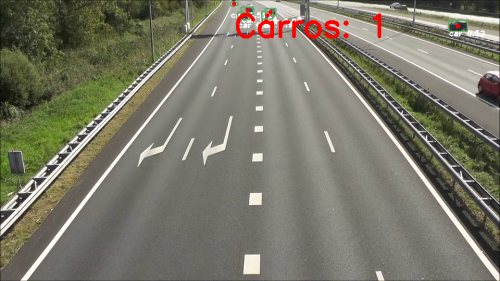

150 [[442, 4, 14, 6, 449, 7], [463, 13, 23, 14, 475, 20], [509, 16, 20, 13, 519, 23], [456, 23, 23, 14, 468, 30], [502, 22, 21, 14, 513, 29], [861, 39, 36, 21, 879, 50]] [0.50515723, 0.8389326, 0.87953967, 0.87846327, 0.89539057, 0.5182942] [2, 2, 2, 2, 2, 2]


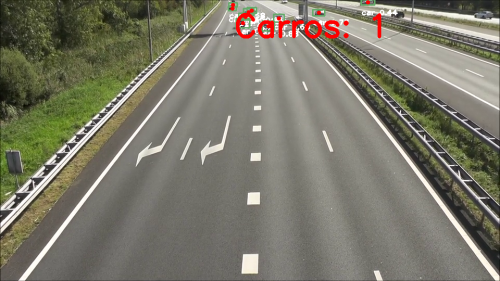

175 [[439, 5, 16, 8, 447, 9], [693, -1, 26, 10, 706, 4], [438, 12, 15, 8, 446, 16], [467, 16, 20, 13, 477, 23], [474, 14, 18, 11, 483, 20], [600, 18, 23, 12, 612, 24], [458, 25, 25, 13, 471, 32], [525, 27, 20, 15, 535, 35], [453, 35, 26, 18, 466, 44], [503, 40, 23, 19, 515, 50]] [0.5789346, 0.444919, 0.46478048, 0.44966072, 0.84190786, 0.76905346, 0.71172595, 0.63306665, 0.93319386, 0.8295567] [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


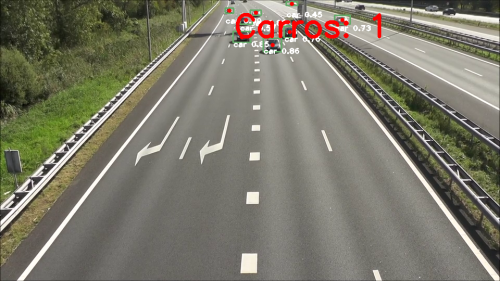

200 [[549, 3, 22, 7, 560, 7], [432, 15, 16, 10, 440, 20], [480, 19, 21, 10, 491, 24], [460, 29, 24, 17, 472, 38], [642, 29, 30, 17, 657, 38], [545, 50, 21, 22, 556, 61], [447, 60, 34, 21, 464, 71], [505, 73, 35, 26, 523, 86]] [0.45078835, 0.89297044, 0.87964725, 0.5670165, 0.72932583, 0.7570867, 0.8478521, 0.8589147] [2, 2, 2, 2, 2, 2, 2, 2]


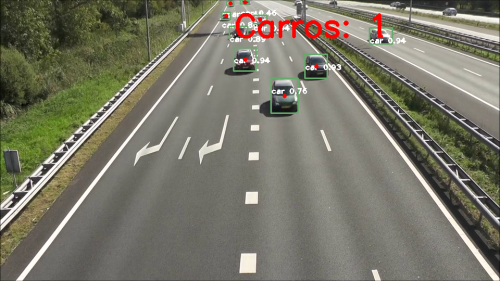

225 [[435, 2, 13, 8, 442, 6], [461, 0, 17, 7, 470, 4], [425, 23, 17, 14, 434, 30], [486, 29, 26, 16, 499, 37], [440, 50, 35, 25, 458, 63], [709, 53, 44, 31, 731, 69], [448, 91, 43, 45, 470, 114], [585, 104, 43, 46, 607, 127], [520, 150, 52, 67, 546, 184]] [0.40707463, 0.45910788, 0.86381406, 0.94363153, 0.88656026, 0.9386365, 0.93620354, 0.9332933, 0.7604547] [2, 2, 2, 2, 2, 2, 2, 2, 2]


KeyboardInterrupt: ignored

In [37]:
cap = cv2.VideoCapture('./projeto/videos/Car2167.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
writer = cv2.VideoWriter('./projeto/videos/novo_Car2165.mp4', cv2.VideoWriter_fourcc(*'DIVX'),20,(width, height))

print(width, height)
if cap.isOpened() == False:
    print('error file not found')

cod_frame=0
inicio = int(round(time.time() * 1000))
detectados = []

carros = 0


while cap.isOpened():
    cod_frame+=1
    ret, frame = cap.read()
    if ret == True:

        #frame_volume_objetos = preprocesso_encontrar_objetos_bordas(frame);
        #desenha_retangulo_objeto(frame, frame_volume_objetos)

        #BGR -> RGB
        blob = cv2.dnn.blobFromImage(frame, 0.00392,(320,320),(0,0,0),True)
        net.setInput(blob)
        outs = net.forward(outputLayers)

        class_ids ,confidences , boxes = encontrar_objetos_dnn(outs)

        desenha_box(frame, boxes, class_ids, confidences)

        for i in range(len(boxes)):
          x,y,w,h,cx,cy = boxes[i]
          detectados.append((x,y,w,h,cx,cy))
          cv2.circle(frame, (cx,cy) , 4, (0, 0, 255), -1)
        
        for (x,y,w,h,cx,cy) in detectados:
          if (390 + 8) > cy > (390 - 8):
            carros += 1
            detectados.remove((x,y,w,h,cx,cy))
            print("Carros detectados: " + str(carros))

        text = f'Carros: {carros}'
        cv2.putText(frame, text, (0, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)
        
        
        if cod_frame % 25 == 0:
          nome_foto = 'foto_'+str(cod_frame)+'.png'
          cv2.imwrite(nome_foto, imutils.resize(frame, width=500))
          cv2_imshow(cv2.imread(nome_foto))
          #cv2_imshow(frame_volume_objetos)
          print(cod_frame, boxes, confidences, class_ids)
        
        
        writer.write(frame)

    else:
        break



cap.release()
writer.release()

In [ ]:
x = [[1]]
x[0][0]